In [153]:
import numpy as np
import pandas as pd

import datetime
from pytz import timezone

from pytrends.request import TrendReq

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from functools import reduce
import re

import os

# https://medium.com/@bewerunge.franz/google-trends-how-to-acquire-daily-data-for-broad-time-frames-b6c6dfe200e6
# trend scaling = take daily data and multiply by monthly metric (daily* month /100)

# https://www.youtube.com/watch?v=cuTUbPQk2R4&ab_channel=KostadinRistovski



# https://www.medrxiv.org/content/10.1101/2021.02.18.21251966v1.full

# study suggests that Google trends is biased :
#     quote: However, search activity may, for example, 
#         be triggered by curiosity following news reports of suicide deaths,
#         particularly celebrity deaths
        

In [2]:
dataframes = []
for file in os.listdir("country_covid"):
    dataframes.append(pd.read_csv(f'country_covid/{file}'))

France_Covid, Germany_Covid, UK_Covid = dataframes[0], dataframes[1], dataframes[2]

In [3]:
type(France_Covid["date"][0])

str

In [4]:
def plot(*dataframes):
    
    plt.rcParams["figure.figsize"] = (25,10)
    plt.rcParams['ytick.labelsize'] = 18
    plt.rcParams['xtick.labelsize'] = 18
    
    switch = input("type c for cases or d for deaths :")
    if switch == "c":
        var = "daily_case_count"
    elif switch == "d":
        var = "daily_death_count"
    else:
        print("error retype var please")
    
    for df in dataframes:
        limit = df[var].max()
    
    for i ,df in enumerate(dataframes):
        df["date"] = pd.to_datetime(df["date"])
        plt.plot(df["date"], df[var], label =f'{i}')
    
    if switch =="c":
        limit = 2*limit
    if switch =="d":
        limit = limit+limit/2
    
    plt.ylim(0, limit)
    plt.xlim(df["date"].min(), df["date"].max())
    plt.xlabel("time", fontsize =20)
    plt.ylabel("count", fontsize =20)
    plt.title(f"evolution of {var} across time", fontsize=30)
    plt.legend(loc="upper left")
    plt.grid(True)

    return plt.show()

# Plots

type c for cases or d for deaths :c


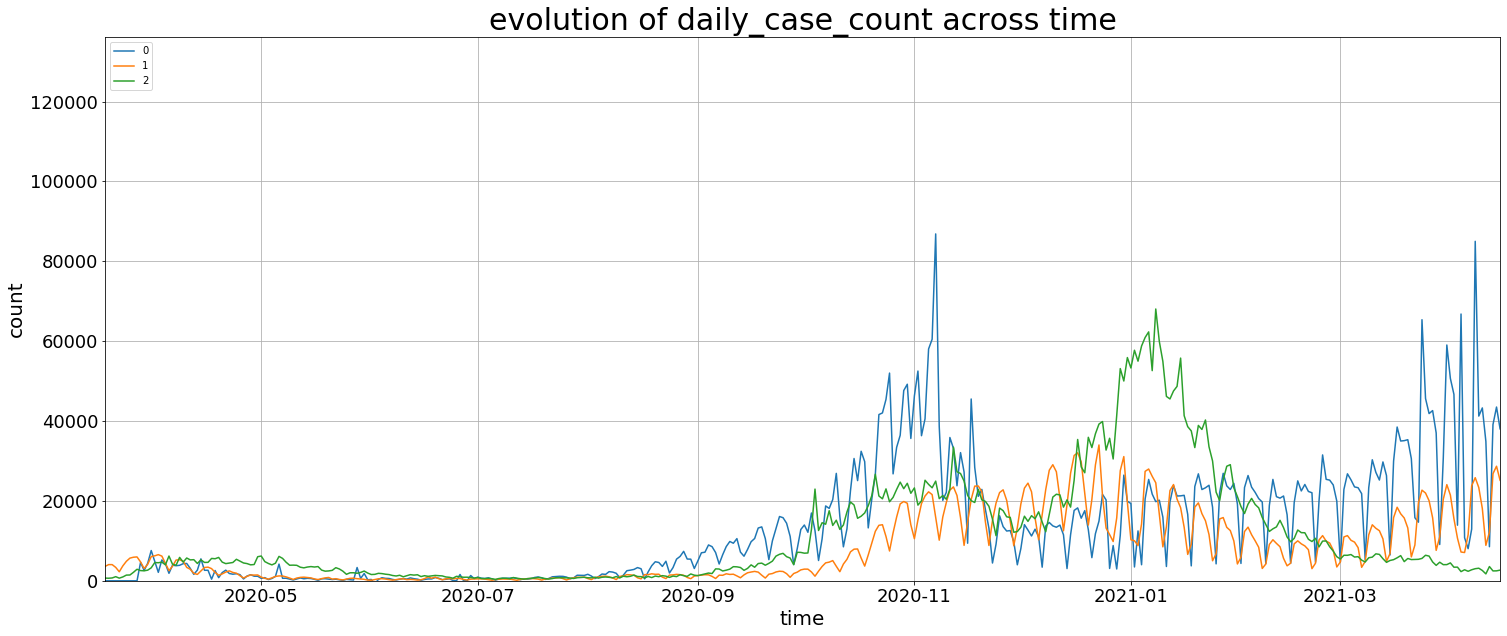

In [5]:
plot(France_Covid, Germany_Covid, UK_Covid)

type c for cases or d for deaths :d


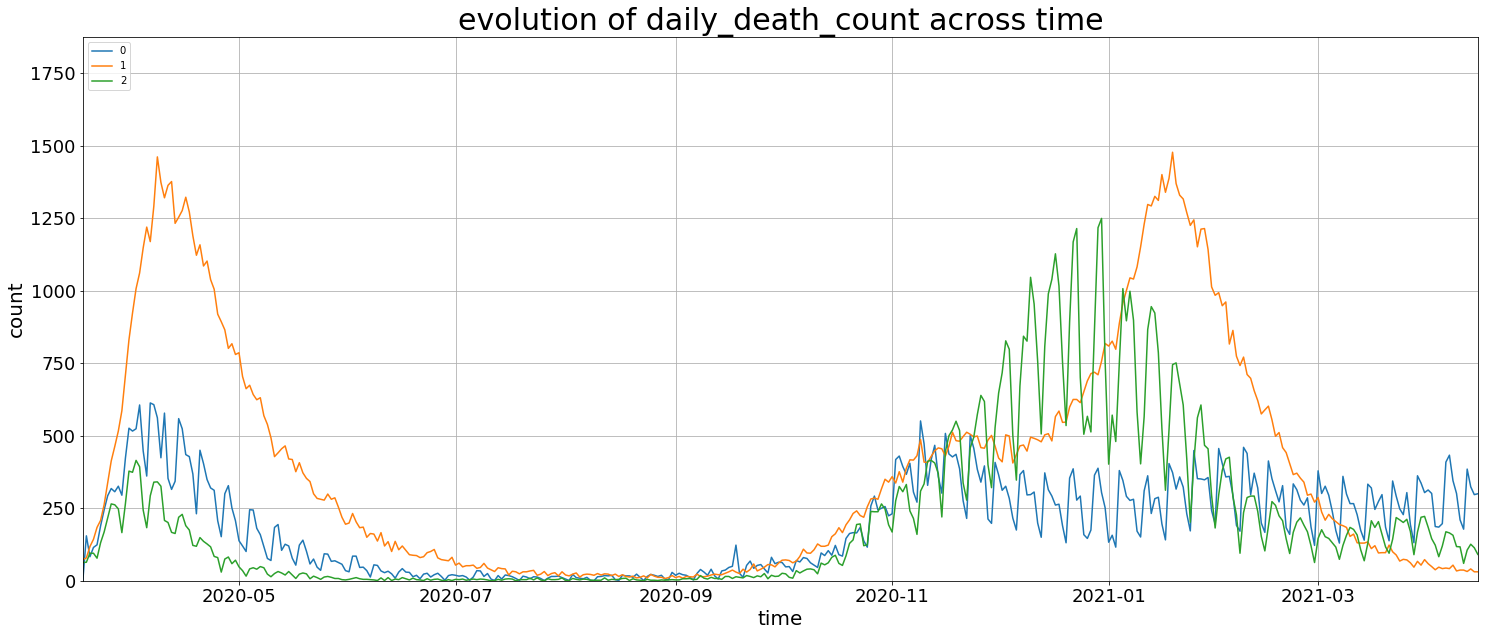

In [6]:
plot(France_Covid, UK_Covid, Germany_Covid)

# Google trends 

In [7]:
pytrends = TrendReq(hl="en-US", tz=360)

In [8]:
#Get time frame of coviddataframes 
time_frame_daily = pd.date_range(start=dataframes[0]["date"].min(), end=dataframes[0]["date"].max(),
                  freq ="D", name="time_frame_daily")

In [9]:
def date_range(start, end, intv):
    diff = (end  - start ) / intv
    for i in range(intv):
        yield (start + diff * i).strftime("%Y%m%d")
    yield end.strftime("%Y%m%d")

In [10]:
mid_point = list(date_range(time_frame_daily.min(),
                                time_frame_daily.max(), intv = 2))[1]

In [11]:
time_frame = str(time_frame_daily.min().strftime("%Y-%m-%d")) + " " + str(time_frame_daily.max().strftime("%Y-%m-%d"))
time_half_1 = str(time_frame_daily.min().strftime("%Y-%m-%d")) + " " + str(pd.to_datetime(mid_point).strftime("%Y-%m-%d")     )
time_half_2 = str((pd.to_datetime(mid_point)+datetime.timedelta(days =1)).strftime("%Y-%m-%d")) + " " + str(time_frame_daily.max().strftime("%Y-%m-%d"))

In [12]:
def fetch_uniqueword(timeframe: list):
    kw_word = [input("Enter word to add to df: ")]
    pytrends.build_payload(kw_list= kw_word,
                                   cat = 0,
                                   timeframe=timeframe,
                                   geo="FR",
                                   gprop="")
    data = pytrends.interest_over_time()
    data.reset_index(inplace=True)
    data.drop("isPartial", axis=1, inplace=True)
    return data

In [21]:
#by default : google trends aggregates time period to weeks if time period > 7 months
#                                                                         and < 2 years
def fetch_data(time_frame, trends): 
    
    trend_dataframes = []
    for word in trends:
        pytrends.build_payload(kw_list = [word],
                               cat=0,
                               timeframe=time_frame,
                               geo="FR",
                               gprop="")
        data = pytrends.interest_over_time()
        data.reset_index(inplace=True)
        
        data.drop("isPartial", axis=1, inplace=True)
        
        trend_dataframes.append(data)
        
    all_trends = reduce(lambda left,right: pd.merge(left, right, on="date",
                                               how="inner"), trend_dataframes)
    return all_trends

In [82]:
def bind_dailydata(trends):
    binded_data = fetch_data(time_half_1, trends).append(fetch_data(time_half_2, trends))
    binded_data = binded_data.reset_index().drop("index", axis=1)
    return binded_data

In [202]:
potential_trends = ["anxieté", "depression", "suicide", "bipolaire", "crise d'angoisse",
                   "angoisse", "peur du futur", "mauvais sommeil", "malaise angoisse",
                   "panic" , "citalopram" , "escitalopram" , "sertraline" ]
test_oneword = ["fantasme"]
test_trends = ["sensation", "cardiaque", "futur"]

In [203]:
weeks = fetch_data(time_frame, test_trends)
days = bind_dailydata(test_trends)

In [204]:
trends_merged = pd.merge(days, weeks, on="date", how="outer",
                     suffixes=["_day", "_week"])

df_trends = trends_merged.fillna(method="ffill")
df_trends

date  sensation_day  cardiaque_day  futur_day  sensation_week  \
0   2020-03-18             72             58         37             NaN   
1   2020-03-19             82             59         66             NaN   
2   2020-03-20             53             66         57             NaN   
3   2020-03-21             97             60         28             NaN   
4   2020-03-22             84             58         40           100.0   
..         ...            ...            ...        ...             ...   
389 2021-04-11             84             74         22            78.0   
390 2021-04-12             57             60         23            78.0   
391 2021-04-13             63             58         23            78.0   
392 2021-04-14             65             78         26            78.0   
393 2021-04-15             97             58         20            78.0   

     cardiaque_week  futur_week  
0               NaN         NaN  
1               NaN         NaN  
2               NaN         NaN  
3               NaN         NaN  
4              92.0        80.0  
..              ...         ...  
389            87.0        55.0  
390            87.0        55.0  
391            87.0        55.0  
392            87.0        55.0  
393            87.0        55.0  

[394 rows x 7 columns]

In [ ]:
test_merged = pd.merge(days, weeks, on="date", how="outer",
                     suffixes=["_day", "_week"])
df = test_merged.fillna(method="ffill")

# "add agg column to be kept"
df[f"{df.columns[1]}_agg_value"] = df[df.columns[1]]*df[df.columns[2]]/100


In [212]:
for word in test_trends:
    key_words = []
    key_words.append(word.split("_")[0])
    print(key_words)
    
    for count, word in enumerate(key_words):
        dataframes = []
        iterations = count+1
        print(word)
        
        for position in range(iterations):
            frames = df_trends.filter(regex=word[position], axis =1)
            i += 1
            dataframes.append(frames)
            print(dataframes)
            
#doesnt work yet, dataframes are not all loaded in dataframes =[]
# only keeps last iteration 
# havent computed the aggregated values yet either

['sensation']
sensation
[     sensation_day  sensation_week
0               72             NaN
1               82             NaN
2               53             NaN
3               97             NaN
4               84           100.0
..             ...             ...
389             84            78.0
390             57            78.0
391             63            78.0
392             65            78.0
393             97            78.0

[394 rows x 2 columns]]
['cardiaque']
cardiaque
[     cardiaque_day  cardiaque_week
0               58             NaN
1               59             NaN
2               66             NaN
3               60             NaN
4               58            92.0
..             ...             ...
389             74            87.0
390             60            87.0
391             58            87.0
392             78            87.0
393             58            87.0

[394 rows x 2 columns]]
['futur']
futur
[     futur_day  futur_week
0           37  

In [ ]:
#doesnt work yet

def time_aggregated_trend_score(week_timeframe, day_timeframe, trends):
    dataframes = []
    daily = bind_dailydata(trends)
    weekly = fetch_data(week_timeframe, trends)
    base_timeframe = daily["date"]
    
    merged = pd.merge(base_timeframe, daily[]
    
    return dataframes

In [ ]:
def word_trend_plot(keyword, name :str):
    arg = str(keyword)
    plt.rcParams["figure.figsize"] = (20,8)
    plt.plot(keyword["date"], keyword[name])
    plt.title("trend evo for 'suicide'")
    plt.xlabel("time")
    plt.ylabel("trend score")
    plt.grid(True)
    return plt.show()